# Multinomial Naive Bayes Modeling

## Pull & Clean Datasets

In [3]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')

In [5]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [9]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [10]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Clean-Up including Hashtags (#) and Direct Mentions (@)

In [13]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [14]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [17]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [18]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [19]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test]

## Pipeline for TF-IDF on Multinomial Bayes

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
tfidf_mb_pipe = Pipeline([
 ('tfidf', TfidfVectorizer()),
 ('SMOTE', SMOTE(n_jobs = -1)),
 ('mnb', MultinomialNB())
])

In [41]:
tfidf_mb_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('mnb', MultinomialNB())])

In [18]:
tfidf_mnb_params = {
    'tfidf__max_features':[None, 27_000, 10_000],
    'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
    'SMOTE__sampling_strategy':['auto', 0.75, 0.9], 
    'tfidf__binary':[False, True],
    'tfidf__norm': ['l1', 'l2']
}

In [19]:
from sklearn.model_selection import GridSearchCV

In [46]:
gs_tfidf_mnb = GridSearchCV(tfidf_mb_pipe,
                            param_grid=tfidf_mnb_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [48]:
gs_tfidf_mnb.fit(token_docs, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'tfidf__binary': [False, True],
                         'tfidf__max_features': [None, 27000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__norm': ['l1', 'l2']},
             verbose=1)

In [49]:
gs_tfidf_mnb.best_score_

0.9253677256258689

In [50]:
gs_tfidf_mnb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), norm='l1')),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [51]:
gs_tfidf_mnb.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'tfidf__binary': False,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l1'}

## Best Possible Multinomial Bayes Model with TF-IDF

In [22]:
tfidf_mb_best_pipeline = Pipeline([
                                   ('tfidf', TfidfVectorizer(max_features = None, 
                                                             ngram_range = (1,2), 
                                                             binary = False, norm = 'l1')),
                                   ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
                                   ('mnb', MultinomialNB())
                                   ])

In [23]:
tfidf_mb_best_pipeline.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), norm='l1')),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [54]:
tfidf_mb_best_pipeline.score(token_docs, y_train)

0.9472055870166995

In [20]:
from sklearn.model_selection import cross_val_score

In [56]:
cross_val_score(tfidf_mb_best_pipeline, token_docs, y_train, cv = 8)

array([0.92488059, 0.92574902, 0.92936749, 0.92545955, 0.9234332 ,
       0.92951223, 0.92647272, 0.92906775])

In [57]:
tfidf_mb_best_pipeline.score(test_token_docs, y_test)

0.9289332754378347

In [21]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

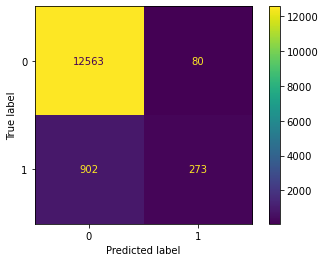

In [59]:
plot_confusion_matrix(tfidf_mb_best_pipeline, test_token_docs, y_test)

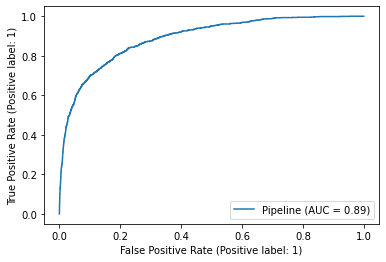

In [60]:
plot_roc_curve(tfidf_mb_best_pipeline, test_token_docs, y_test)

In [61]:
y_hat = tfidf_mb_best_pipeline.predict(test_token_docs)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12643
           1       0.77      0.23      0.36      1175

    accuracy                           0.93     13818
   macro avg       0.85      0.61      0.66     13818
weighted avg       0.92      0.93      0.91     13818



In [1]:
tfidf_mb_best_pipelin

NameError: name 'tfidf_mb_best_pipeline' is not defined

## Pipeline for Count Vectorizer on Multinomial Bayes

In [62]:
cv_mb_pipeline = Pipeline([
 ('cv', CountVectorizer()),
 ('SMOTE', SMOTE(n_jobs = -1)),
 ('mnb', MultinomialNB())
])

In [63]:
cv_mb_pipeline.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('mnb', MultinomialNB())])

In [22]:
cv_mnb_params = {
    'cv__max_features':[None, 27_000, 10_000],
    'cv__ngram_range':[(1,1), (1,2), (2,2)],
    'cv__binary':[False, True],
    'SMOTE__sampling_strategy':['auto', 0.75, 0.9],
    }

In [65]:
gs_cv_mnb = GridSearchCV(cv_mb_pipeline,
                            param_grid=cv_mnb_params, 
                            cv = 3, 
                            verbose = 1,
                         n_jobs = -1)

In [66]:
gs_cv_mnb.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__binary': [False, True],
                         'cv__max_features': [None, 27000, 10000],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [67]:
gs_cv_mnb.best_score_

0.9281720957995304

In [68]:
gs_cv_mnb.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [69]:
gs_cv_mnb.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'cv__binary': True,
 'cv__max_features': None,
 'cv__ngram_range': (1, 2)}

## Best Possible Multinomial Bayes Model with Count Vectorizer

In [70]:
cv_best_mb_pipeline = Pipeline([
                                ('cv', CountVectorizer(max_features = None, ngram_range = (1,2), 
                                                       binary = True)),
                                ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
                                ('mnb', MultinomialNB())
])

In [71]:
cv_best_mb_pipeline.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [72]:
cv_best_mb_pipeline.score(token_docs, y_train)

0.9798447648857448

In [73]:
cross_val_score(cv_best_mb_pipeline, token_docs, y_train, cv = 5)

array([0.9275441 , 0.93206079, 0.93061335, 0.93287498, 0.93079428])

In [74]:
cv_best_mb_pipeline.score(test_token_docs, y_test)

0.9354465190331451

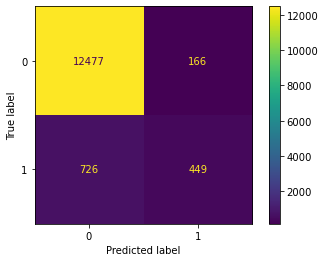

In [75]:
plot_confusion_matrix(cv_best_mb_pipeline, test_token_docs, y_test)

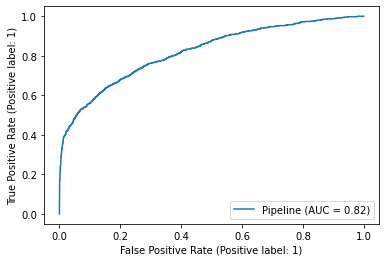

In [76]:
plot_roc_curve(cv_best_mb_pipeline, test_token_docs, y_test);

In [77]:
y_hat_2 = cv_best_mb_pipeline.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12643
           1       0.73      0.38      0.50      1175

    accuracy                           0.94     13818
   macro avg       0.84      0.68      0.73     13818
weighted avg       0.93      0.94      0.93     13818



## NLP Clean-Up including ONLY language

In [23]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [24]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## GridSearch Pipeline for TFIDF / Multinomial Bayes

In [23]:
tfidf_mb_pipe_2 = Pipeline([
 ('tfidf', TfidfVectorizer()),
 ('SMOTE', SMOTE(n_jobs = -1)),
 ('mnb', MultinomialNB())
])

In [24]:
tfidf_mb_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('mnb', MultinomialNB())])

In [28]:
gs_tfidf_mnb_2 = GridSearchCV(tfidf_mb_pipe_2,
                            param_grid=tfidf_mnb_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [29]:
gs_tfidf_mnb_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'tfidf__binary': [False, True],
                         'tfidf__max_features': [None, 27000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__norm': ['l1', 'l2']},
             verbose=1)

In [30]:
gs_tfidf_mnb_2.best_score_

0.9256029437659684

In [31]:
gs_tfidf_mnb_2.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), norm='l1')),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [32]:
gs_tfidf_mnb_2.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'tfidf__binary': False,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l1'}

## Best TFIDF Multinomial Bayes Model

In [25]:
tfidf_best_mb_pipe_2 = Pipeline([
 ('tfidf', TfidfVectorizer(max_features = None, ngram_range = (1, 2),
                          norm = 'l1', binary = False)),
 ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
 ('mnb', MultinomialNB())
])

In [26]:
tfidf_best_mb_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), norm='l1')),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [27]:
tfidf_best_mb_pipe_2.score(token_docs_2, y_train)

0.9474407917352681

In [28]:
cross_val_score(tfidf_best_mb_pipe_2, token_docs_2, y_train, cv = 8)

array([0.9234332 , 0.92560428, 0.92748589, 0.92545955, 0.92560428,
       0.92922275, 0.92285425, 0.92964679])

In [29]:
tfidf_best_mb_pipe_2.score(test_token_docs_2, y_test)

0.9273411492256477

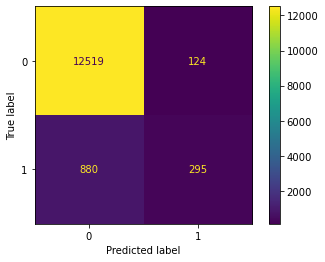

In [30]:
plot_confusion_matrix(tfidf_best_mb_pipe_2, test_token_docs_2, y_test)

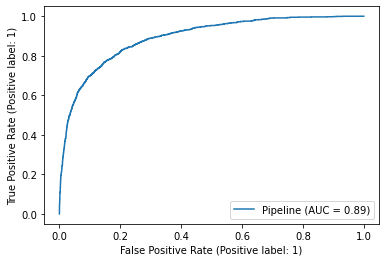

In [31]:
plot_roc_curve(tfidf_best_mb_pipe_2, test_token_docs_2, y_test)

In [32]:
y_hat_3 = tfidf_best_mb_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12643
           1       0.70      0.25      0.37      1175

    accuracy                           0.93     13818
   macro avg       0.82      0.62      0.67     13818
weighted avg       0.91      0.93      0.91     13818



## Grid Search Pipeline with Count Vectorizer and Multinomial Bayes

In [33]:
cv_mb_pipeline_2 = Pipeline([
 ('cv', CountVectorizer()),
 ('SMOTE', SMOTE(n_jobs = -1)),
 ('mnb', MultinomialNB())
])

In [34]:
cv_mb_pipeline_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('mnb', MultinomialNB())])

In [35]:
gs_cv_mnb_2 = GridSearchCV(cv_mb_pipeline_2,
                            param_grid=cv_mnb_params, 
                            cv = 3, 
                            verbose = 1,
                         n_jobs = -1)

In [36]:
gs_cv_mnb_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__binary': [False, True],
                         'cv__max_features': [None, 27000, 10000],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [37]:
gs_cv_mnb_2.best_score_

0.9298547308668131

In [38]:
gs_cv_mnb_2.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [39]:
gs_cv_mnb_2.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'cv__binary': True,
 'cv__max_features': None,
 'cv__ngram_range': (1, 2)}

## Best Multinomial Bayes Model with Count Vectorizer

In [40]:
cv_best_mb_pipeline_2 = Pipeline([
 ('cv', CountVectorizer(max_features = None, ngram_range = (1,2),
                       binary = True)),
 ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
 ('mnb', MultinomialNB())
])

In [41]:
cv_best_mb_pipeline_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv', CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('mnb', MultinomialNB())])

In [42]:
cv_best_mb_pipeline_2.score(token_docs_2, y_train)

0.9787772973168569

In [43]:
cross_val_score(cv_best_mb_pipeline_2, token_docs_2, y_train, cv = 8)

array([0.9260385 , 0.92980171, 0.93182805, 0.93182805, 0.93139383,
       0.93385439, 0.93182805, 0.93181818])

In [44]:
cv_best_mb_pipeline_2.score(test_token_docs_2, y_test)

0.9342162396873643

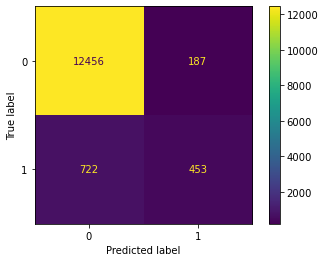

In [45]:
plot_confusion_matrix(cv_best_mb_pipeline_2, test_token_docs_2, y_test)

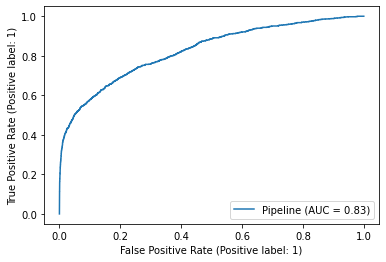

In [46]:
plot_roc_curve(cv_best_mb_pipeline_2, test_token_docs_2, y_test)

In [48]:
y_hat_4 = cv_best_mb_pipeline_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.96     12643
           1       0.71      0.39      0.50      1175

    accuracy                           0.93     13818
   macro avg       0.83      0.69      0.73     13818
weighted avg       0.93      0.93      0.93     13818

